# Step 1. Reload files & Import Modules - 匯入模組

## 1-1. Reload files - 重讀檔案

In [1]:
import sys
print(sys.version)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]


In [2]:
# reload file if you eaited them
import crawler104, config.search_params, async_example, threaded_async_job, jobs104
import data_lake, data_warehouse, translation, data_analysis
import matplotlib.pyplot as plt

import importlib
importlib.reload(crawler104)
importlib.reload(async_example)
importlib.reload(threaded_async_job)
importlib.reload(jobs104)
importlib.reload(config.search_params)
importlib.reload(data_lake)
importlib.reload(data_warehouse)
importlib.reload(translation)
importlib.reload(data_analysis)

<module 'data_analysis' from 'C:\\Users\\Rekam\\develop\\python\\jobscan\\data_analysis.py'>

## 1-2. Import Modules - 匯入模組

In [3]:
# import library
from crawler104 import Crawler104
from config.search_params import get_filter_params
from data_lake import DataLake
from data_warehouse import DataWarehouse
from data_analysis import DataAnalysis

In [4]:
# 快速執行 reload & import
%run main.py

# Step 2. Data Source - 爬蟲抓資料

## 2-1. Filter Setting - 過濾條件

In [5]:
# custom filter params for search - for yidti
role = {'ro':'全職'}
keyword = {'keyword':"後端工程師 python"}
# area = {'area':['新北市', '台北市', '桃園市', '台中市']}
isnew = {'isnew':'三日內'}
jobexp = {'jobexp':['1年以下', '1-3年']}
# 預設
mode = {'mode':'列表'}  # 一次能呈現比較多筆資料
order = {'order':'日期排序'}
asc = {'asc':'遞減'}
# filter_params = get_filter_params(role, keyword, area, isnew, jobexp, mode, order, asc)
filter_params = get_filter_params(role, keyword, isnew, jobexp, mode, order, asc)
# keywords for filter job again
job_keywords = ('工程','資料','python','data','數據','後端')
# Exclude keywords to filter out companies related to gambling or others that I don't want to consider.
company_exclude = ('新加坡商冕創有限公司','新博軟體開發股份有限公司','現觀科技股份有限公司'
                   ,'全富數位有限公司','杰思數位有限公司','博凡星國際有限公司',
                  '尊博科技股份有限公司','新騎資訊有限公司','新加坡商鈦坦科技股份有限公司台灣分公司',
                   '豪穎科技股份有限公司','塶樂微創有限公司','磐弈有限公司',
                   '聯訊網路有限公司','冶金數位科技有限公司','肥貓科技有限公司',
                   '無名科技有限公司','博澭科技有限公司','緯雲股份有限公司',
                   '風采有限公司','英屬維京群島商嘉碼科技有限公司台灣分公司',
                   '冠宇數位科技股份有限公司','英仕國際有限公司','元遊科技有限公司',
                   '禾碩資訊股份有限公司','向上集團_向上國際科技股份有限公司',
                   '弈樂科技股份有限公司','馬來西亞商極限電腦科技有限公司台灣分公司',
                   '樂夠科技有限公司','威智國際有限公司','紅信科技有限公司',
                   '深思設計有限公司','揚帆科技有限公司','晶要資訊有限公司',
                   '九七科技股份有限公司','臣悅科技有限公司','尊承科技股份有限公司',
                   '遊戲河流有限公司','唐傳有限公司','捷訊資訊有限公司',
                   '逍遙遊科技有限公司','澄果資訊服務有限公司','果遊科技有限公司',
                   '昱泉國際股份有限公司','博星數位股份有限公司',
                  )
user = "yidti"
crawler = Crawler104(filter_params, user)
print(f"設定排除{len(company_exclude)}家公司")

設定排除44家公司


## 2-2. Web Crawler - 抓取Jobs清單

In [6]:
# chrome for testing -> https://googlechromelabs.github.io/chrome-for-testing/
crawler.run(job_keywords, company_exclude)

url: https://www.104.com.tw/jobs/search/?ro=1&keyword=%E5%BE%8C%E7%AB%AF%E5%B7%A5%E7%A8%8B%E5%B8%AB+python&isnew=3&jobexp=1%2C3&mode=l&order=16&asc=0


Loading: 100%|██████████| 64/64 [01:35<00:00,  1.49s/page]


載入64頁 | 載入1890筆資料 | 過濾剩1402筆資料 | 花費 114.34 秒


## 2-3. Web Scraper - 抓取Jobs內容(異步&多線程)

In [9]:
# 新增 temp 暫存檔 parquet
crawler.detail()

exclude exist and close data
Remove from parquet, leaving 0 remaining to scrape .


Processing jobs: 0job [00:00, ?job/s]

Scraping Details for 0 Jobs | 花費 0.06 秒


## 2-3. Export Flie - 輸出至Excel

In [10]:
# output to excel file (job)
crawler.export_excel()

CSV文件保存成功: output/yidti-2024-05-05.xlsx


# Step 3. Data Lake - 資料存入NoSQL

In [11]:
# ouput to noSQL (job, company, industry)
data_lake = DataLake()
data_lake.save_nosql(user, crawler)
data_lake.filter(job_keywords, company_exclude)

Update 1397 records, Insert 4 records in jobs_104 collection
job keywords - 已刪除不符合關鍵字的文件數量: 0
company exclude - 已刪除符合條件的文件數量: 0


# Step 4 - Data Warehouse - 資料存入MySQL

In [12]:
# 快速執行 reload & import
%run main.py

In [13]:
data_lake  = DataLake()
data_Warehouse = DataWarehouse()
data_Warehouse.initial_db()
data_Warehouse.save_sql(data_lake)

DB is created (job_db)
Successfully executed SQL script
Successfully executed SQL script
更新表格:company,寫入14筆
更新表格:industry,寫入1筆
無須更新:location_city_region
更新表格:location,寫入19筆
無須更新:experience
無須更新:education
更新表格:category_item,寫入6筆
更新表格:category,寫入80筆
更新表格:major_item,寫入2筆
更新表格:major,寫入59筆
無須更新:language_item
更新表格:language,寫入33筆
更新表格:tool_item,寫入5筆
更新表格:tool,寫入110筆
更新表格:skill_item,寫入6筆
更新表格:skill,寫入111筆
更新表格:benefits,寫入6筆
無須更新:type
無須更新:management
無須更新:business_trip
更新表格:working_hours,寫入1筆
無須更新:vacation
無須更新:available
無須更新:quantity
更新表格:job_info,寫入33筆


# Step 5 - Exploratory Data Analysis (EDA) - 探索性資料分析

In [15]:
# 快速執行 reload & import
%run main.py
da = DataAnalysis()
import pandas as pd

# 抓取 education
t1_columns = ["job_id"]  # 事實表要選擇的欄位名稱列表
t2_columns = ["education"]  # 維度表要選擇的欄位名稱列表
df_education = da.merge_data("job_info", "education", "education_id", "id", t1_columns, t2_columns)

# 抓取 city
t1_columns = ["job_id"]  # 事實表要選擇的欄位名稱列表
t2_columns = ["city_region_id"]  # 維度表要選擇的欄位名稱列表
df_location = da.merge_data("job_info", "location", "location_id", "id", t1_columns, t2_columns)

t1_columns = ["city_region_id"]  # 事實表要選擇的欄位名稱列表
t2_columns = ["city", "region"]  # 維度表要選擇的欄位名稱列表
df_city_region = da.merge_data("location", "location_city_region", "city_region_id", "id", t1_columns, t2_columns)

df_city = pd.merge(df_location, df_city_region, on="city_region_id", how ="left").drop_duplicates(subset='job_id')

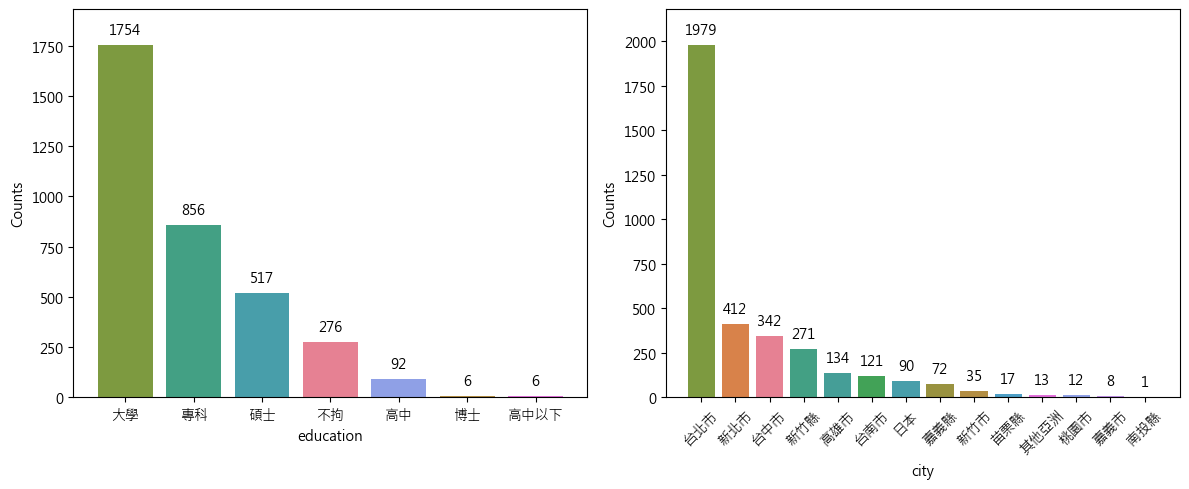

In [17]:
# 測試!!!
# 快速執行 reload & import
%run main.py
da = DataAnalysis()
# 创建一个包含两个子图的图形
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
da.plot_countplot(df_education, 'education', ax=axes[0])
da.plot_countplot(df_city, 'city', ax=axes[1])


# Step 99. Test Area - 測試區域